In [ ]:
# !pip install pytorch_lightning
# !pip install tensorboardX

In [2]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
# import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
DATA_DIR = "/Users/aleksandr/Downloads/"

In [9]:
data = pd.read_json(DATA_DIR + "data_seminar_04.json", lines=True)

In [10]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [11]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

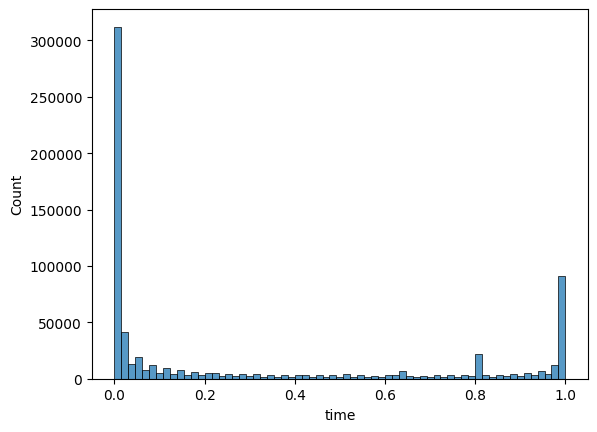

In [12]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [18]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572000, 71290, 71954)

In [19]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
        return torch.sum(context * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [21]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values), 
                torch.from_numpy(self.train_data["time"].values)
            )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values), 
            torch.from_numpy(self.val_data["time"].values)
            )
        
        if stage == "test" or stage is None:  
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
            )
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [32]:
net = ContextualRanker(embedding_dim=74)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='cpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs --host localhost

In [33]:
trainer.fit(
    net, 
    data_module
)


  | Name    | Type      | Params
--------------------------------------
0 | context | Embedding | 3.7 M 
1 | track   | Embedding | 3.7 M 
--------------------------------------
7.4 M     Trainable params
0         Non-trainable params
7.4 M     Total params
29.600    Total estimated model params size (MB)


Epoch 0:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 280/315 [00:11<00:01, 23.91it/s, loss=65.7, v_num=11]
Validation: 0it [00:00, ?it/s]
Epoch 0:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 313/315 [00:12<00:00, 25.06it/s, loss=65.7, v_num=11]


Epoch 1:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:10<00:01, 25.65it/s, loss=56.4, v_num=11, val_loss=64.60]
Validation: 0it [00:00, ?it/s]
Epoch 1:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 311/315 [00:11<00:00, 27.20it/s, loss=56.4, v_num=11, val_loss=64.60]


Epoch 2:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:10<00:01, 27.10it/s, loss=48.3, v_num=11, val_loss=58.70]
Validation: 0it [00:00, ?it/s]
Epoch 2:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 309/315 [00:10<00:00, 28.66it/s, loss=48.3, v_num=11, val_loss=58.70]


Epoch 3:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:10<00:01, 27.04it/s, loss=41.7, v_num=11, val_loss=53.60]
Validation: 0it [00:00, ?it/s]
Epoch 3:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 307/315 [00:10<00:00, 28.55it/s, loss=41.7, v_num=11, val_loss=53.60]


Epoch 4:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:11<00:01, 25.14it/s, loss=36.2, v_num=11, val_loss=49.30]
Validation: 0it [00:00, ?it/s]
Epoch 4:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 305/315 [00:11<00:00, 26.30it/s, loss=36.2, v_num=11, val_loss=49.30]


Epoch 5:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:10<00:01, 26.87it/s, loss=31.8, v_num=11, val_loss=45.50]
Validation: 0it [00:00, ?it/s]
Epoch 5:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 303/315 [00:10<00:00, 28.08it/s, loss=31.8, v_num=11, val_loss=45.50]


Epoch 6:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:10<00:01, 26.41it/s, loss=27.4, v_num=11, val_loss=42.20]
Validation: 0it [00:00, ?it/s]
Epoch 6:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 301/315 [00:10<00:00, 27.50it/s, loss=27.4, v_num=11, val_loss=42.20]


Epoch 7:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:10<00:01, 26.19it/s, loss=23.7, v_num=11, val_loss=39.20]
Validation: 0it [00:00, ?it/s]
Epoch 7:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 299/315 [00:11<00:00, 27.17it/s, loss=23.7, v_num=11, val_loss=39.20]


Epoch 8:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:10<00:01, 26.77it/s, loss=20.5, v_num=11, val_loss=36.60]
Validation: 0it [00:00, ?it/s]
Epoch 8:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 297/315 [00:10<00:00, 27.61it/s, loss=20.5, v_num=11, val_loss=36.60]


Epoch 9:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:10<00:01, 26.60it/s, loss=18.2, v_num=11, val_loss=34.20]
Validation: 0it [00:00, ?it/s]
Epoch 9:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 295/315 [00:10<00:00, 27.45it/s, loss=18.2, v_num=11, val_loss=34.20]


Epoch 10:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.90it/s, loss=15.8, v_num=11, val_loss=32.10]
Validation: 0it [00:00, ?it/s]
Epoch 10:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 293/315 [00:11<00:00, 25.47it/s, loss=15.8, v_num=11, val_loss=32.10]


Epoch 11:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.64it/s, loss=13.5, v_num=11, val_loss=30.10]
Validation: 0it [00:00, ?it/s]
Epoch 11:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 291/315 [00:11<00:00, 26.14it/s, loss=13.5, v_num=11, val_loss=30.10]


Epoch 12:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 280/315 [00:10<00:01, 26.00it/s, loss=12, v_num=11, val_loss=28.40]
Validation: 0it [00:00, ?it/s]
Epoch 12:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 289/315 [00:10<00:00, 26.36it/s, loss=12, v_num=11, val_loss=28.40]


Epoch 13:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.84it/s, loss=10.6, v_num=11, val_loss=26.80]
Validation: 0it [00:00, ?it/s]
Epoch 13:  91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 287/315 [00:10<00:01, 26.16it/s, loss=10.6, v_num=11, val_loss=26.80]


Epoch 14:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.36it/s, loss=9.05, v_num=11, val_loss=25.30]
Validation: 0it [00:00, ?it/s]
Epoch 14:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 285/315 [00:11<00:01, 25.62it/s, loss=9.05, v_num=11, val_loss=25.30]


Epoch 15:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.02it/s, loss=8.06, v_num=11, val_loss=23.90]
Validation: 0it [00:00, ?it/s]
Epoch 15:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 283/315 [00:11<00:01, 25.15it/s, loss=8.06, v_num=11, val_loss=23.90]


Epoch 16:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.35it/s, loss=6.92, v_num=11, val_loss=22.60]
Validation: 0it [00:00, ?it/s]
Epoch 16:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 281/315 [00:11<00:01, 25.39it/s, loss=6.92, v_num=11, val_loss=22.60]


Epoch 17:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.35it/s, loss=6.05, v_num=11, val_loss=21.40]
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                                                                                                                                                     | 0/35 [00:00<?, ?it/s]


Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:12<00:00, 26.10it/s, loss=6.05, v_num=11, val_loss=20.30]


Epoch 18:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 26.70it/s, loss=5.32, v_num=11, val_loss=20.30]
Validation: 0it [00:00, ?it/s]
Epoch 18:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 313/315 [00:11<00:00, 28.15it/s, loss=5.32, v_num=11, val_loss=20.30]


Epoch 19:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 26.14it/s, loss=4.64, v_num=11, val_loss=19.20]
Validation: 0it [00:00, ?it/s]
Epoch 19:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 311/315 [00:11<00:00, 27.56it/s, loss=4.64, v_num=11, val_loss=19.20]


Epoch 20:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.77it/s, loss=4.15, v_num=11, val_loss=18.20]
Validation: 0it [00:00, ?it/s]
Epoch 20:  98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 309/315 [00:11<00:00, 26.02it/s, loss=4.15, v_num=11, val_loss=18.20]


Epoch 21:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.71it/s, loss=3.59, v_num=11, val_loss=17.30]
Validation: 0it [00:00, ?it/s]
Epoch 21:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 307/315 [00:11<00:00, 27.03it/s, loss=3.59, v_num=11, val_loss=17.30]


Epoch 22:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.55it/s, loss=3.13, v_num=11, val_loss=16.40]
Validation: 0it [00:00, ?it/s]
Epoch 22:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 305/315 [00:11<00:00, 26.76it/s, loss=3.13, v_num=11, val_loss=16.40]


Epoch 23:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.61it/s, loss=2.71, v_num=11, val_loss=15.60]
Validation: 0it [00:00, ?it/s]
Epoch 23:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 303/315 [00:11<00:00, 26.68it/s, loss=2.71, v_num=11, val_loss=15.60]


Epoch 24:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.82it/s, loss=2.42, v_num=11, val_loss=14.80]
Validation: 0it [00:00, ?it/s]
Epoch 24:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 301/315 [00:11<00:00, 26.75it/s, loss=2.42, v_num=11, val_loss=14.80]


Epoch 25:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.94it/s, loss=2.09, v_num=11, val_loss=14.00]
Validation: 0it [00:00, ?it/s]
Epoch 25:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 299/315 [00:11<00:00, 25.95it/s, loss=2.09, v_num=11, val_loss=14.00]


Epoch 26:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.27it/s, loss=1.87, v_num=11, val_loss=13.30]
Validation: 0it [00:00, ?it/s]
Epoch 26:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 297/315 [00:11<00:00, 26.03it/s, loss=1.87, v_num=11, val_loss=13.30]


Epoch 27:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.24it/s, loss=1.63, v_num=11, val_loss=12.60]
Validation: 0it [00:00, ?it/s]
Epoch 27:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 295/315 [00:11<00:00, 25.90it/s, loss=1.63, v_num=11, val_loss=12.60]


Epoch 28:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.71it/s, loss=1.42, v_num=11, val_loss=11.90]
Validation: 0it [00:00, ?it/s]
Epoch 28:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 293/315 [00:11<00:00, 26.28it/s, loss=1.42, v_num=11, val_loss=11.90]


Epoch 29:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.51it/s, loss=1.25, v_num=11, val_loss=11.20]
Validation: 0it [00:00, ?it/s]
Epoch 29:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 291/315 [00:11<00:00, 26.09it/s, loss=1.25, v_num=11, val_loss=11.20]


Epoch 30:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 280/315 [00:11<00:01, 24.31it/s, loss=1.1, v_num=11, val_loss=10.60]
Validation: 0it [00:00, ?it/s]
Epoch 30:  92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 289/315 [00:11<00:01, 24.68it/s, loss=1.1, v_num=11, val_loss=10.60]


Epoch 31:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.28it/s, loss=0.967, v_num=11, val_loss=9.970]
Validation: 0it [00:00, ?it/s]
Epoch 31:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 287/315 [00:11<00:01, 25.52it/s, loss=0.967, v_num=11, val_loss=9.970]


Epoch 32:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.99it/s, loss=0.838, v_num=11, val_loss=9.380]
Validation: 0it [00:00, ?it/s]
Epoch 32:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 285/315 [00:11<00:01, 25.13it/s, loss=0.838, v_num=11, val_loss=9.380]


Epoch 33:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.90it/s, loss=0.747, v_num=11, val_loss=8.810]
Validation: 0it [00:00, ?it/s]
Epoch 33:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 283/315 [00:11<00:01, 25.05it/s, loss=0.747, v_num=11, val_loss=8.810]


Epoch 34:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.46it/s, loss=0.667, v_num=11, val_loss=8.250]
Validation: 0it [00:00, ?it/s]
Epoch 34:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 281/315 [00:11<00:01, 25.49it/s, loss=0.667, v_num=11, val_loss=8.250]


Epoch 35:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.74it/s, loss=0.587, v_num=11, val_loss=7.710]
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                                                                                                                                                     | 0/35 [00:00<?, ?it/s]


Epoch 35: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:11<00:00, 26.33it/s, loss=0.587, v_num=11, val_loss=7.190]


Epoch 36:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 26.24it/s, loss=0.521, v_num=11, val_loss=7.190]
Validation: 0it [00:00, ?it/s]
Epoch 36:  99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 313/315 [00:11<00:00, 27.77it/s, loss=0.521, v_num=11, val_loss=7.190]


Epoch 37:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.77it/s, loss=0.456, v_num=11, val_loss=6.690]
Validation: 0it [00:00, ?it/s]
Epoch 37:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 311/315 [00:11<00:00, 27.30it/s, loss=0.456, v_num=11, val_loss=6.690]


Epoch 38:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.96it/s, loss=0.408, v_num=11, val_loss=6.210]
Validation: 0it [00:00, ?it/s]
Epoch 38:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 309/315 [00:11<00:00, 27.37it/s, loss=0.408, v_num=11, val_loss=6.210]


Epoch 39:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.31it/s, loss=0.365, v_num=11, val_loss=5.740]
Validation: 0it [00:00, ?it/s]
Epoch 39:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 307/315 [00:11<00:00, 26.55it/s, loss=0.365, v_num=11, val_loss=5.740]


Epoch 40:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.37it/s, loss=0.321, v_num=11, val_loss=5.290]
Validation: 0it [00:00, ?it/s]
Epoch 40:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 305/315 [00:11<00:00, 26.45it/s, loss=0.321, v_num=11, val_loss=5.290]


Epoch 41:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.78it/s, loss=0.288, v_num=11, val_loss=4.870]
Validation: 0it [00:00, ?it/s]
Epoch 41:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 303/315 [00:11<00:00, 25.86it/s, loss=0.288, v_num=11, val_loss=4.870]


Epoch 42:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.93it/s, loss=0.255, v_num=11, val_loss=4.460]
Validation: 0it [00:00, ?it/s]
Epoch 42:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 301/315 [00:11<00:00, 25.91it/s, loss=0.255, v_num=11, val_loss=4.460]


Epoch 43:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.13it/s, loss=0.228, v_num=11, val_loss=4.070]
Validation: 0it [00:00, ?it/s]
Epoch 43:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 299/315 [00:11<00:00, 26.00it/s, loss=0.228, v_num=11, val_loss=4.070]


Epoch 44:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.73it/s, loss=0.208, v_num=11, val_loss=3.700]
Validation: 0it [00:00, ?it/s]
Epoch 44:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 297/315 [00:11<00:00, 25.41it/s, loss=0.208, v_num=11, val_loss=3.700]


Epoch 45:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 23.75it/s, loss=0.186, v_num=11, val_loss=3.350]
Validation: 0it [00:00, ?it/s]
Epoch 45:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 295/315 [00:12<00:00, 24.50it/s, loss=0.186, v_num=11, val_loss=3.350]


Epoch 46:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 25.22it/s, loss=0.167, v_num=11, val_loss=3.020]
Validation: 0it [00:00, ?it/s]
Epoch 46:  93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 293/315 [00:11<00:00, 25.77it/s, loss=0.167, v_num=11, val_loss=3.020]


Epoch 47:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.91it/s, loss=0.151, v_num=11, val_loss=2.710]
Validation: 0it [00:00, ?it/s]
Epoch 47:  92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 291/315 [00:11<00:00, 25.36it/s, loss=0.151, v_num=11, val_loss=2.710]


Epoch 48:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.75it/s, loss=0.137, v_num=11, val_loss=2.420]
Validation: 0it [00:00, ?it/s]
Epoch 48:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 289/315 [00:11<00:01, 25.11it/s, loss=0.137, v_num=11, val_loss=2.420]


Epoch 49:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:12<00:01, 21.88it/s, loss=0.126, v_num=11, val_loss=2.160]
Validation: 0it [00:00, ?it/s]
Epoch 49:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 287/315 [00:12<00:01, 22.21it/s, loss=0.126, v_num=11, val_loss=2.160]


Epoch 50:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:12<00:01, 21.54it/s, loss=0.114, v_num=11, val_loss=1.910]
Validation: 0it [00:00, ?it/s]
Epoch 50:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 285/315 [00:13<00:01, 21.78it/s, loss=0.114, v_num=11, val_loss=1.910]


Epoch 51:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.43it/s, loss=0.102, v_num=11, val_loss=1.690]
Validation: 0it [00:00, ?it/s]
Epoch 51:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 283/315 [00:11<00:01, 24.48it/s, loss=0.102, v_num=11, val_loss=1.690]


Epoch 52:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:12<00:01, 21.99it/s, loss=0.0953, v_num=11, val_loss=1.490]
Validation: 0it [00:00, ?it/s]
Epoch 52:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 281/315 [00:12<00:01, 22.02it/s, loss=0.0953, v_num=11, val_loss=1.490]


Epoch 53:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 23.77it/s, loss=0.0873, v_num=11, val_loss=1.300]
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                                                                                                                                                     | 0/35 [00:00<?, ?it/s]


Epoch 53: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:12<00:00, 25.38it/s, loss=0.0873, v_num=11, val_loss=1.140]


Epoch 54:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.49it/s, loss=0.0827, v_num=11, val_loss=1.140]
Validation: 0it [00:00, ?it/s]
Epoch 54:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 313/315 [00:11<00:00, 27.91it/s, loss=0.0827, v_num=11, val_loss=1.140]


Epoch 55:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.78it/s, loss=0.0762, v_num=11, val_loss=0.994]
Validation: 0it [00:00, ?it/s]
Epoch 55:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 311/315 [00:11<00:00, 28.15it/s, loss=0.0762, v_num=11, val_loss=0.994]


Epoch 56:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 27.19it/s, loss=0.0714, v_num=11, val_loss=0.865]
Validation: 0it [00:00, ?it/s]
Epoch 56:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 309/315 [00:10<00:00, 28.39it/s, loss=0.0714, v_num=11, val_loss=0.865]


Epoch 57:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.78it/s, loss=0.0685, v_num=11, val_loss=0.752]
Validation: 0it [00:00, ?it/s]
Epoch 57:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 307/315 [00:10<00:00, 28.07it/s, loss=0.0685, v_num=11, val_loss=0.752]


Epoch 58:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.66it/s, loss=0.0665, v_num=11, val_loss=0.653]
Validation: 0it [00:00, ?it/s]
Epoch 58:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 305/315 [00:10<00:00, 27.87it/s, loss=0.0665, v_num=11, val_loss=0.653]


Epoch 59:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.85it/s, loss=0.0643, v_num=11, val_loss=0.568]
Validation: 0it [00:00, ?it/s]
Epoch 59:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 303/315 [00:10<00:00, 27.92it/s, loss=0.0643, v_num=11, val_loss=0.568]


Epoch 60:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.10it/s, loss=0.0612, v_num=11, val_loss=0.495]
Validation: 0it [00:00, ?it/s]
Epoch 60:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 301/315 [00:11<00:00, 27.06it/s, loss=0.0612, v_num=11, val_loss=0.495]


Epoch 61:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.02it/s, loss=0.0596, v_num=11, val_loss=0.433]
Validation: 0it [00:00, ?it/s]
Epoch 61:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 299/315 [00:11<00:00, 27.02it/s, loss=0.0596, v_num=11, val_loss=0.433]


Epoch 62:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.77it/s, loss=0.0576, v_num=11, val_loss=0.380]
Validation: 0it [00:00, ?it/s]
Epoch 62:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 297/315 [00:11<00:00, 25.54it/s, loss=0.0576, v_num=11, val_loss=0.380]


Epoch 63:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.69it/s, loss=0.0583, v_num=11, val_loss=0.336]
Validation: 0it [00:00, ?it/s]
Epoch 63:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 295/315 [00:11<00:00, 25.22it/s, loss=0.0583, v_num=11, val_loss=0.336]


Epoch 64:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 25.50it/s, loss=0.0599, v_num=11, val_loss=0.299]
Validation: 0it [00:00, ?it/s]
Epoch 64:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 293/315 [00:11<00:00, 26.04it/s, loss=0.0599, v_num=11, val_loss=0.299]


Epoch 65:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 25.09it/s, loss=0.0578, v_num=11, val_loss=0.269]
Validation: 0it [00:00, ?it/s]
Epoch 65:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 291/315 [00:11<00:00, 25.62it/s, loss=0.0578, v_num=11, val_loss=0.269]


Epoch 66:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 25.99it/s, loss=0.0585, v_num=11, val_loss=0.243]
Validation: 0it [00:00, ?it/s]
Epoch 66:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 289/315 [00:10<00:00, 26.31it/s, loss=0.0585, v_num=11, val_loss=0.243]


Epoch 67:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.06it/s, loss=0.0579, v_num=11, val_loss=0.222]
Validation: 0it [00:00, ?it/s]
Epoch 67:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 287/315 [00:10<00:01, 26.28it/s, loss=0.0579, v_num=11, val_loss=0.222]


Epoch 68:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 25.81it/s, loss=0.0571, v_num=11, val_loss=0.205]
Validation: 0it [00:00, ?it/s]
Epoch 68:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 285/315 [00:10<00:01, 25.91it/s, loss=0.0571, v_num=11, val_loss=0.205]


Epoch 69:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.32it/s, loss=0.0567, v_num=11, val_loss=0.191]
Validation: 0it [00:00, ?it/s]
Epoch 69:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 283/315 [00:10<00:01, 26.46it/s, loss=0.0567, v_num=11, val_loss=0.191]


Epoch 70:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 25.46it/s, loss=0.0585, v_num=11, val_loss=0.179]
Validation: 0it [00:00, ?it/s]
Epoch 70:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 281/315 [00:11<00:01, 25.50it/s, loss=0.0585, v_num=11, val_loss=0.179]


Epoch 71:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.08it/s, loss=0.0578, v_num=11, val_loss=0.169]
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                                                                                                                                                     | 0/35 [00:00<?, ?it/s]


Epoch 71: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:11<00:00, 27.65it/s, loss=0.0578, v_num=11, val_loss=0.161]


Epoch 72:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.38it/s, loss=0.0583, v_num=11, val_loss=0.161]
Validation: 0it [00:00, ?it/s]
Epoch 72:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 313/315 [00:11<00:00, 27.73it/s, loss=0.0583, v_num=11, val_loss=0.161]


Epoch 73:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 27.04it/s, loss=0.0591, v_num=11, val_loss=0.154]
Validation: 0it [00:00, ?it/s]
Epoch 73:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 311/315 [00:10<00:00, 28.55it/s, loss=0.0591, v_num=11, val_loss=0.154]


Epoch 74:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.71it/s, loss=0.0584, v_num=11, val_loss=0.148]
Validation: 0it [00:00, ?it/s]
Epoch 74:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 309/315 [00:10<00:00, 28.12it/s, loss=0.0584, v_num=11, val_loss=0.148]


Epoch 75:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 26.44it/s, loss=0.057, v_num=11, val_loss=0.144]
Validation: 0it [00:00, ?it/s]
Epoch 75:  97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 307/315 [00:11<00:00, 27.65it/s, loss=0.057, v_num=11, val_loss=0.144]


Epoch 76:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.30it/s, loss=0.0584, v_num=11, val_loss=0.139]
Validation: 0it [00:00, ?it/s]
Epoch 76:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 305/315 [00:11<00:00, 27.33it/s, loss=0.0584, v_num=11, val_loss=0.139]


Epoch 77:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 25.20it/s, loss=0.0578, v_num=11, val_loss=0.136]
Validation: 0it [00:00, ?it/s]
Epoch 77:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 303/315 [00:11<00:00, 26.28it/s, loss=0.0578, v_num=11, val_loss=0.136]


Epoch 78:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 25.91it/s, loss=0.0585, v_num=11, val_loss=0.133]
Validation: 0it [00:00, ?it/s]
Epoch 78:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 301/315 [00:11<00:00, 26.74it/s, loss=0.0585, v_num=11, val_loss=0.133]


Epoch 79:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 26.30it/s, loss=0.0581, v_num=11, val_loss=0.130]
Validation: 0it [00:00, ?it/s]
Epoch 79:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 299/315 [00:11<00:00, 26.97it/s, loss=0.0581, v_num=11, val_loss=0.130]


Epoch 80:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.79it/s, loss=0.0573, v_num=11, val_loss=0.128]
Validation: 0it [00:00, ?it/s]
Epoch 80:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 297/315 [00:11<00:00, 25.51it/s, loss=0.0573, v_num=11, val_loss=0.128]


Epoch 81:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.51it/s, loss=0.0561, v_num=11, val_loss=0.126]
Validation: 0it [00:00, ?it/s]
Epoch 81:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 295/315 [00:11<00:00, 25.22it/s, loss=0.0561, v_num=11, val_loss=0.126]


Epoch 82:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.85it/s, loss=0.0566, v_num=11, val_loss=0.124]
Validation: 0it [00:00, ?it/s]
Epoch 82:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 293/315 [00:11<00:00, 25.37it/s, loss=0.0566, v_num=11, val_loss=0.124]


Epoch 83:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.34it/s, loss=0.0559, v_num=11, val_loss=0.122]
Validation: 0it [00:00, ?it/s]
Epoch 83:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 291/315 [00:11<00:00, 24.74it/s, loss=0.0559, v_num=11, val_loss=0.122]


Epoch 84:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 25.11it/s, loss=0.0567, v_num=11, val_loss=0.121]
Validation: 0it [00:00, ?it/s]
Epoch 84:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 289/315 [00:11<00:01, 25.42it/s, loss=0.0567, v_num=11, val_loss=0.121]


Epoch 85:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.52it/s, loss=0.0557, v_num=11, val_loss=0.120]
Validation: 0it [00:00, ?it/s]
Epoch 85:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 287/315 [00:11<00:01, 24.85it/s, loss=0.0557, v_num=11, val_loss=0.120]


Epoch 86:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.97it/s, loss=0.0556, v_num=11, val_loss=0.119]
Validation: 0it [00:00, ?it/s]
Epoch 86:  90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 285/315 [00:11<00:01, 25.20it/s, loss=0.0556, v_num=11, val_loss=0.119]


Epoch 87:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.55it/s, loss=0.0558, v_num=11, val_loss=0.118]
Validation: 0it [00:00, ?it/s]
Epoch 87:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 283/315 [00:11<00:01, 24.67it/s, loss=0.0558, v_num=11, val_loss=0.118]


Epoch 88:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.48it/s, loss=0.0562, v_num=11, val_loss=0.117]
Validation: 0it [00:00, ?it/s]
Epoch 88:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 281/315 [00:11<00:01, 24.51it/s, loss=0.0562, v_num=11, val_loss=0.117]


Epoch 89:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.26it/s, loss=0.0552, v_num=11, val_loss=0.117]
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                                                                                                                                                     | 0/35 [00:00<?, ?it/s]


Epoch 89: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:12<00:00, 25.76it/s, loss=0.0552, v_num=11, val_loss=0.116]


Epoch 90:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 25.93it/s, loss=0.0549, v_num=11, val_loss=0.116]
Validation: 0it [00:00, ?it/s]
Epoch 90:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 313/315 [00:11<00:00, 27.31it/s, loss=0.0549, v_num=11, val_loss=0.116]


Epoch 91:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 25.87it/s, loss=0.0542, v_num=11, val_loss=0.115]
Validation: 0it [00:00, ?it/s]
Epoch 91:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 311/315 [00:11<00:00, 27.11it/s, loss=0.0542, v_num=11, val_loss=0.115]


Epoch 92:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:10<00:01, 25.54it/s, loss=0.054, v_num=11, val_loss=0.115]
Validation: 0it [00:00, ?it/s]
Epoch 92:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 309/315 [00:11<00:00, 26.71it/s, loss=0.054, v_num=11, val_loss=0.115]


Epoch 93:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 25.36it/s, loss=0.0542, v_num=11, val_loss=0.115]
Validation: 0it [00:00, ?it/s]
Epoch 93:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 307/315 [00:11<00:00, 26.57it/s, loss=0.0542, v_num=11, val_loss=0.115]


Epoch 94:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:10<00:01, 25.48it/s, loss=0.0541, v_num=11, val_loss=0.114]
Validation: 0it [00:00, ?it/s]
Epoch 94:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 305/315 [00:11<00:00, 26.55it/s, loss=0.0541, v_num=11, val_loss=0.114]


Epoch 95:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.78it/s, loss=0.0531, v_num=11, val_loss=0.114]
Validation: 0it [00:00, ?it/s]
Epoch 95:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 303/315 [00:11<00:00, 25.76it/s, loss=0.0531, v_num=11, val_loss=0.114]


Epoch 96:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 25.00it/s, loss=0.0537, v_num=11, val_loss=0.114]
Validation: 0it [00:00, ?it/s]
Epoch 96:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 301/315 [00:11<00:00, 25.90it/s, loss=0.0537, v_num=11, val_loss=0.114]


Epoch 97:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 24.40it/s, loss=0.0532, v_num=11, val_loss=0.113]
Validation: 0it [00:00, ?it/s]
Epoch 97:  95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 299/315 [00:11<00:00, 25.32it/s, loss=0.0532, v_num=11, val_loss=0.113]


Epoch 98:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.87it/s, loss=0.053, v_num=11, val_loss=0.113]
Validation: 0it [00:00, ?it/s]
Epoch 98:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 297/315 [00:11<00:00, 25.58it/s, loss=0.053, v_num=11, val_loss=0.113]


Epoch 99:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 24.87it/s, loss=0.052, v_num=11, val_loss=0.113]
Validation: 0it [00:00, ?it/s]
Epoch 99:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 295/315 [00:11<00:00, 25.46it/s, loss=0.052, v_num=11, val_loss=0.113]


Epoch 100:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:11<00:01, 23.59it/s, loss=0.0526, v_num=11, val_loss=0.113]
Validation: 0it [00:00, ?it/s]
Epoch 100:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 293/315 [00:12<00:00, 24.05it/s, loss=0.0526, v_num=11, val_loss=0.113]


Epoch 101:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 23.67it/s, loss=0.053, v_num=11, val_loss=0.113]
Validation: 0it [00:00, ?it/s]
Epoch 101:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 291/315 [00:12<00:00, 24.19it/s, loss=0.053, v_num=11, val_loss=0.113]


Epoch 102:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 23.55it/s, loss=0.052, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 102:  92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 289/315 [00:12<00:01, 23.75it/s, loss=0.052, v_num=11, val_loss=0.112]


Epoch 103:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 23.33it/s, loss=0.0517, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 103:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 287/315 [00:12<00:01, 23.50it/s, loss=0.0517, v_num=11, val_loss=0.112]


Epoch 104:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 23.12it/s, loss=0.0523, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 104:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 285/315 [00:12<00:01, 23.20it/s, loss=0.0523, v_num=11, val_loss=0.112]


Epoch 105:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 22.22it/s, loss=0.0502, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 105:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 283/315 [00:12<00:01, 22.32it/s, loss=0.0502, v_num=11, val_loss=0.112]


Epoch 106:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:12<00:01, 22.49it/s, loss=0.053, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 106:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 281/315 [00:12<00:01, 22.52it/s, loss=0.053, v_num=11, val_loss=0.112]


Epoch 107:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 22.89it/s, loss=0.0522, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                                                                                                                                                     | 0/35 [00:00<?, ?it/s]


Epoch 107: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:13<00:00, 24.16it/s, loss=0.0522, v_num=11, val_loss=0.112]


Epoch 108:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:11<00:01, 24.76it/s, loss=0.0519, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 108:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 313/315 [00:12<00:00, 25.99it/s, loss=0.0519, v_num=11, val_loss=0.112]


Epoch 109:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:11<00:01, 24.32it/s, loss=0.0522, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 109:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 311/315 [00:12<00:00, 25.41it/s, loss=0.0522, v_num=11, val_loss=0.112]


Epoch 110:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:11<00:01, 23.51it/s, loss=0.0515, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 110:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 309/315 [00:12<00:00, 24.70it/s, loss=0.0515, v_num=11, val_loss=0.112]


Epoch 111:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:11<00:01, 24.00it/s, loss=0.0516, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 111:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 307/315 [00:12<00:00, 25.09it/s, loss=0.0516, v_num=11, val_loss=0.112]


Epoch 112:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:12<00:01, 23.20it/s, loss=0.052, v_num=11, val_loss=0.112]
Validation: 0it [00:00, ?it/s]
Epoch 112:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 305/315 [00:12<00:00, 23.99it/s, loss=0.052, v_num=11, val_loss=0.112]


Epoch 113:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:12<00:01, 23.28it/s, loss=0.052, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 113:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 303/315 [00:12<00:00, 24.15it/s, loss=0.052, v_num=11, val_loss=0.111]


Epoch 114:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 23.13it/s, loss=0.0509, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 114:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 301/315 [00:12<00:00, 23.96it/s, loss=0.0509, v_num=11, val_loss=0.111]


Epoch 115:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:11<00:01, 23.43it/s, loss=0.0499, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 115:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 299/315 [00:12<00:00, 24.01it/s, loss=0.0499, v_num=11, val_loss=0.111]


Epoch 116:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:12<00:01, 22.84it/s, loss=0.051, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 116:  94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 297/315 [00:12<00:00, 23.46it/s, loss=0.051, v_num=11, val_loss=0.111]


Epoch 117:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:13<00:01, 20.99it/s, loss=0.0512, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 117:  94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 295/315 [00:13<00:00, 21.62it/s, loss=0.0512, v_num=11, val_loss=0.111]


Epoch 118:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:12<00:01, 22.76it/s, loss=0.051, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 118:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 293/315 [00:12<00:00, 23.20it/s, loss=0.051, v_num=11, val_loss=0.111]


Epoch 119:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 22.73it/s, loss=0.0503, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 119:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 291/315 [00:12<00:01, 23.07it/s, loss=0.0503, v_num=11, val_loss=0.111]


Epoch 120:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 22.99it/s, loss=0.0506, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 120:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 289/315 [00:12<00:01, 23.25it/s, loss=0.0506, v_num=11, val_loss=0.111]


Epoch 121:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 22.77it/s, loss=0.0505, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 121:  91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 287/315 [00:12<00:01, 23.07it/s, loss=0.0505, v_num=11, val_loss=0.111]


Epoch 122:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 22.98it/s, loss=0.0506, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 122:  90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 285/315 [00:12<00:01, 23.19it/s, loss=0.0506, v_num=11, val_loss=0.111]


Epoch 123:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 22.43it/s, loss=0.0496, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 123:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 283/315 [00:12<00:01, 22.54it/s, loss=0.0496, v_num=11, val_loss=0.111]


Epoch 124:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 22.97it/s, loss=0.0498, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 124:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 281/315 [00:12<00:01, 22.99it/s, loss=0.0498, v_num=11, val_loss=0.111]


Epoch 125:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 22.71it/s, loss=0.0501, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Validation:   0%|                                                                                                                                                                                     | 0/35 [00:00<?, ?it/s]


Epoch 125: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:13<00:00, 24.20it/s, loss=0.0501, v_num=11, val_loss=0.111]


Epoch 126:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:11<00:01, 25.24it/s, loss=0.0497, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 126:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 313/315 [00:11<00:00, 26.55it/s, loss=0.0497, v_num=11, val_loss=0.111]


Epoch 127:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:11<00:01, 23.68it/s, loss=0.0505, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 127:  99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 311/315 [00:12<00:00, 24.80it/s, loss=0.0505, v_num=11, val_loss=0.111]


Epoch 128:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:12<00:01, 23.15it/s, loss=0.051, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 128:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 309/315 [00:12<00:00, 23.83it/s, loss=0.051, v_num=11, val_loss=0.111]


Epoch 129:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:13<00:01, 20.61it/s, loss=0.0499, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 129:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 307/315 [00:14<00:00, 21.43it/s, loss=0.0499, v_num=11, val_loss=0.111]


Epoch 130:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:14<00:01, 19.22it/s, loss=0.0492, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 130:  97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 305/315 [00:15<00:00, 20.16it/s, loss=0.0492, v_num=11, val_loss=0.111]


Epoch 131:  89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 280/315 [00:12<00:01, 21.82it/s, loss=0.0499, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 131:  96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 303/315 [00:13<00:00, 22.76it/s, loss=0.0499, v_num=11, val_loss=0.111]


Epoch 132:  89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 280/315 [00:11<00:01, 23.88it/s, loss=0.05, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 132:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 301/315 [00:12<00:00, 24.71it/s, loss=0.05, v_num=11, val_loss=0.111]


Epoch 133:  89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 280/315 [00:11<00:01, 23.92it/s, loss=0.041, v_num=11, val_loss=0.111]
Validation: 0it [00:00, ?it/s]
Epoch 133:  95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 298/315 [00:12<00:00, 24.77it/s, loss=0.041, v_num=11, val_loss=0.111]


Epoch 133: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 315/315 [00:12<00:00, 25.41it/s, loss=0.041, v_num=11, val_loss=0.111]


In [34]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=74)

In [35]:
trainer.test(best, data_module)

Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 190.07it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        avg_loss            0.15381823480129242
        rdm_loss             0.27867391705513
        test_loss           0.10978836566209793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.10978836566209793,
  'avg_loss': 0.15381823480129242,
  'rdm_loss': 0.27867391705513}]

In [36]:
trainer.test(best, data_module)

Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 141/141 [00:00<00:00, 198.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        avg_loss            0.15381823480129242
        rdm_loss            0.2764795422554016
        test_loss           0.10978836566209793
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.10978836566209793,
  'avg_loss': 0.15381823480129242,
  'rdm_loss': 0.2764795422554016}]

## Compute top recommendations

In [39]:
track_meta = pd.read_json(DATA_DIR + "tracks.json", lines=True)

In [40]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [41]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [42]:
k = 100
with open(DATA_DIR + "tracks_with_recs6.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

50000it [00:50, 990.81it/s] 


In [ ]:
track = 3916
embedding = context_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

In [ ]:
k = 10
neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]